<a href="https://colab.research.google.com/github/Thrilok28021996/Course_work/blob/master/coursework_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import os

In [0]:
# This code has been taken from this link https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
# For LOADING THE DATASET FROM THE GOOGLE DRIVE
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [68]:
link ='https://drive.google.com/open?id=1lvMoUF1YzgIEvLW13_wYy_9JR9dTmDuu'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1lvMoUF1YzgIEvLW13_wYy_9JR9dTmDuu


In [69]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocess_data.csv')  
data = pd.read_csv('preprocess_data.csv',encoding='utf-8')
# Dataset is now stored in a Pandas Dataframe
print("Dataset is now Loaded")

Dataset is now Loaded


In [70]:
data.head()

,headline,text
0,keep related supplies area make effort clean d...,photographer keep necessary lens cords batteri...
1,create sketch neopoprealist manner future mura...,see image drawing develops step step however i...
2,get bachelor degree enroll studio based progra...,possible become vfx artist without college deg...
3,start experience interest art understand diffe...,best art investors research pieces art buy som...
4,keep reference materials sketches articles pho...,start planning project work shall likely gathe...


Torch Req

In [0]:
x = data['text'].astype(str)
y = data['headline'].astype(str)

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
def readLangs(text, summary, reverse=False):
    print("Reading lines...")
    pairs =[]
    missing_lines = 0
    # Split every line into pairs and normalize
    for i in range(len(text)):
      try:
        pairs.append([text[i],summary[i]])
      except:
        missing_lines=missing_lines+1
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(summary)
        output_lang = Lang(text)
    else:
        input_lang = Lang(text)
        output_lang = Lang(summary)
    print("total missing indices"+str(missing_lines))
    return input_lang, output_lang, pairs

In [0]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [76]:
input_lang, output_lang, pairs = prepareData( x, y , False)
print(random.choice(pairs))

Reading lines...
total missing indices0
Read 180127 sentence pairs
Counting words...
Counted words:
0         photographer keep necessary lens cords batteri...
1         see image drawing develops step step however i...
2         possible become vfx artist without college deg...
3         best art investors research pieces art buy som...
4         start planning project work shall likely gathe...
                                ...                        
180122    name like might fiddle spelling see alternate ...
180123    name might sound great say loud bedroom find s...
180124    relief printing oldest traditional printing te...
180125    intaglio italian incis ing correspondingly rev...
180126    lithography big term often used refer many dif...
Name: text, Length: 180127, dtype: object 152911
0         keep related supplies area make effort clean d...
1         create sketch neopoprealist manner future mura...
2         get bachelor degree enroll studio based progra...
3         s

In [0]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [78]:
len_summaries = create_lengths(y)
len_articles = create_lengths(x)

print("Summaries:")
print(len_summaries.describe())
print()
print("Articles:")
print(len_articles.describe())

Summaries:
              counts
count  180127.000000
mean      211.691007
std       179.585936
min         3.000000
25%        99.000000
50%       156.000000
75%       271.000000
max     14563.000000

Articles:
              counts
count  180127.000000
mean     1786.784757
std      1752.965176
min         3.000000
25%       719.000000
50%      1233.000000
75%      2121.000000
max     48273.000000


In [79]:
print("\t\t Min\t 25%\t Avg\t 75%\t Max")
print("\nArticle\t\t {}\t{}\t{}\t{}\t{}".format(np.percentile(len_articles,0),np.percentile(len_articles,25),np.percentile(len_articles,50),np.percentile(len_articles,75),np.percentile(len_articles,100)))
print("Summary\t\t {}\t{}\t{}\t{}\t{}".format(np.percentile(len_summaries,0),np.percentile(len_summaries,25),np.percentile(len_summaries,50),np.percentile(len_summaries,75),np.percentile(len_summaries,100)))

		 Min	 25%	 Avg	 75%	 Max

Article		 3.0	719.0	1233.0	2121.0	48273.0
Summary		 3.0	99.0	156.0	271.0	14563.0


In [0]:
MAX_LENGTH = 2500

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    
    loss = 0
    

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
             
        if ei < max_length:
          encoder_outputs[ei] = encoder_output[0, 0]

      

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def trainIters(encoder, decoder, n_iters, print_every, plot_every, learning_rate):
    start = time.time()
    
    print_loss = 0  # Reset every print_every
    plot_loss = 0  # Reset every plot_every


    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss += loss
        plot_loss += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss / print_every
            print_loss = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss = 0

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Article:', pair[0])
        print('Reference summary:', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Summary:', output_sentence)
        print('')

In [91]:
hidden_size = 300
learning_rate = 0.001      # Learning rates 0.0005, 0.001, 0.00146    https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
plot_losses = []
plot_every = 50
print_every =100
n_iters = 1000
dropout = 0.5

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout).to(device)
trainIters(encoder, decoder, n_iters, print_every,plot_every,learning_rate)

2m 56s (- 26m 28s) (100 10%) 5.8585
5m 38s (- 22m 33s) (200 20%) 5.8826
8m 18s (- 19m 23s) (300 30%) 6.1130
10m 58s (- 16m 27s) (400 40%) 5.9328
13m 33s (- 13m 33s) (500 50%) 5.9503
16m 29s (- 10m 59s) (600 60%) 6.0300
19m 4s (- 8m 10s) (700 70%) 6.1394
21m 56s (- 5m 29s) (800 80%) 5.7022
24m 49s (- 2m 45s) (900 90%) 5.8557
27m 35s (- 0m 0s) (1000 100%) 5.7042


<Figure size 432x288 with 0 Axes>

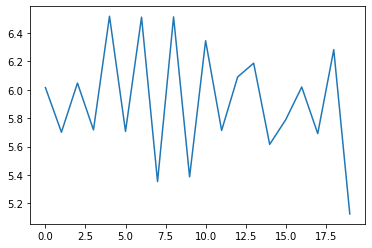

In [92]:
# plotting the losses
import matplotlib.pyplot as plt
%matplotlib inline
showPlot(plot_losses)

In [0]:
torch.save(encoder.state_dict(), './enc.w')
torch.save(decoder.state_dict(), './dec.w')

In [94]:
evaluateRandomly(encoder, decoder, n=2)

Article: simplified version widmark formula bac x formula r gender constant r females males order calculate bac using widmark formula need count many drinks consumed given period precise possible number drinks counted based standard drink size alcohol content rather number glasses bottles etc consumed volume content drinks vary widely standard drink size varies country country drink drink united states standard drink size proof version liqueur gin whiskey approximately ounces forty percent alcohol standard drink size beer five percent volume alcohol twelve ounces standard drink size wine twelve percent volume alcohol five ounces united states standard drink contains approximately fourteen grams alcohol number standard drinks consumed multiply number derive alcohol dose grams give alcohol dose amount alcohol consumed also find alcohol dose using formula x x grams alcohol consumedif area different alcohol content standard drink need multiply number standard drinks consumed alcohol conten